# Analysis of results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
df = pd.read_table('results.tsv', index_col=0)
df

,class,architecture,topology,superfamily,tmvec1,tmvec_student,tmalign,foldseek
seq_ids,,,,,,,,
"107lA00,108lA00",1,1,1,1,0.999900,0.999887,0.99929,4.560000e-26
"107lA00,109lA00",1,1,1,1,0.999929,0.999898,0.99945,5.000000e-27
"107lA00,110lA00",1,1,1,1,0.999920,0.999887,0.99947,7.210000e-26
"107lA00,111lA00",1,1,1,1,0.999960,0.999885,0.99929,1.910000e-26
"107lA00,112lA00",1,1,1,1,0.999958,0.999874,0.99892,3.270000e-26
...,...,...,...,...,...,...,...,...
"1b7jA00,1b7lA00",0,0,0,0,0.480856,0.326075,0.26842,NaN
"1b7jA00,1b7mA00",0,0,0,0,0.490731,0.325220,0.26723,NaN
"1b7kA00,1b7lA00",0,0,0,0,0.478964,0.320446,0.27057,NaN


In [5]:
bins = [0.0, 0.25, 0.5, 0.75, 1.0]
df['bin'] = pd.cut(df['tmalign'], bins=bins, right=True)

In [6]:
methods = ['tmvec1', 'tmvec_student', 'tmalign', 'foldseek']
names = ['TM-Vec', 'TM-Vec Student', 'TM-align', 'Foldseek']

In [7]:
levels = ['class', 'architecture', 'topology', 'superfamily']

Correlation

In [8]:
df_score = df[['tmvec1', 'tmvec_student', 'tmalign']].dropna(how='any')
df_score

,tmvec1,tmvec_student,tmalign
seq_ids,,,
"107lA00,108lA00",0.999900,0.999887,0.99929
"107lA00,109lA00",0.999929,0.999898,0.99945
"107lA00,110lA00",0.999920,0.999887,0.99947
"107lA00,111lA00",0.999960,0.999885,0.99929
"107lA00,112lA00",0.999958,0.999874,0.99892
...,...,...,...
"1b7jA00,1b7lA00",0.480856,0.326075,0.26842
"1b7jA00,1b7mA00",0.490731,0.325220,0.26723
"1b7kA00,1b7lA00",0.478964,0.320446,0.27057


In [9]:
score_bins = np.arange(0, 1.015, 0.015)

In [10]:
text = 'Pearson R = {:.3f}\np-value = {:.2e}\nMAE = {:.3f}\nRMSE = {:.3f}'

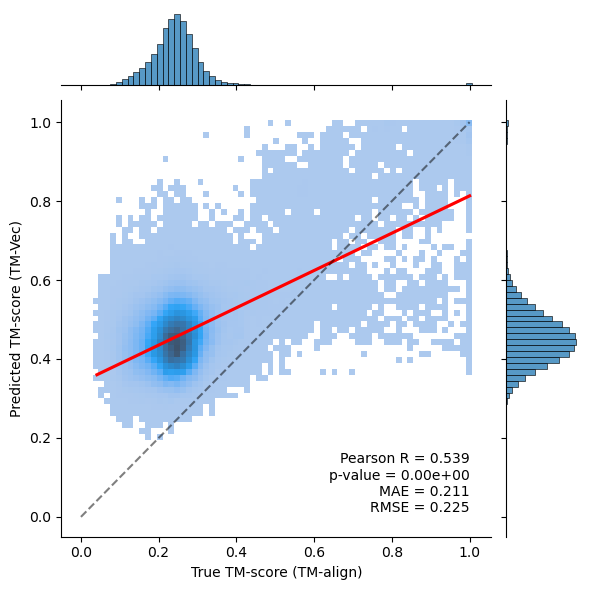

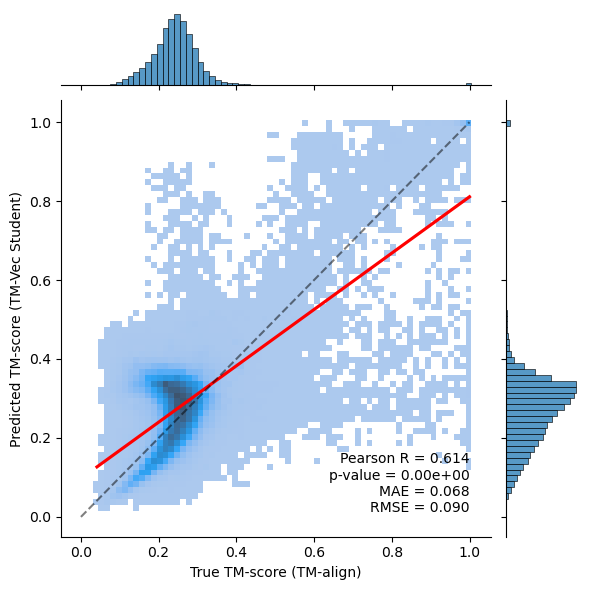

In [11]:
x = df_score['tmalign'].to_numpy()
for i in range(2):
    method, name = methods[i], names[i]

    # Statistics
    y = df_score[method].to_numpy()
    r, p = pearsonr(x, y)
    diff = x - y
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff ** 2))

    # Correlation plot
    g = sns.JointGrid(data=df_score, x='tmalign', y=method, height=6)
    g.plot_joint(sns.histplot, bins=(score_bins, score_bins))
    g.plot_joint(sns.regplot, scatter=False, color='red')
    g.plot_marginals(sns.histplot, bins=score_bins)

    ax = g.ax_joint
    ax.plot((0, 1), (0, 1), 'k--', alpha=0.5)
    ax.text(0.95, 0.05, text.format(r, p, mae, rmse), transform=ax.transAxes, ha='right', va='bottom')
    ax.set_xlabel('True TM-score (TM-align)')
    ax.set_ylabel(f'Predicted TM-score ({name})')

    g.savefig(f'plots/{method}.svg')

Distribution

In [12]:
df_melt = df_score.melt(var_name='Method', value_name='TM-score')

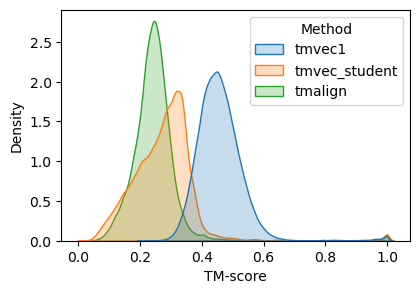

In [13]:
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.kdeplot(data=df_melt, x='TM-score', hue='Method', fill=True, alpha=0.25, ax=ax)
fig.savefig('plots/distribution.svg')

Errors

In [14]:
df_err = df_score[['tmvec1', 'tmvec_student']].sub(df['tmalign'], axis=0).abs()

In [15]:
df_err_melt = df_err.melt(var_name='method', value_name='error')

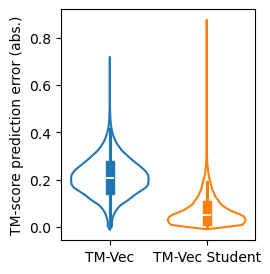

In [16]:
fig, ax = plt.subplots(figsize=(2.5, 3))
sns.violinplot(data=df_err_melt, x='method', y='error', hue='method', order=methods[:2], fill=False, ax=ax)
ax.set_ylabel('TM-score prediction error (abs.)')
ax.set_xlabel(None)
ax.set_xticks(range(2), names[:2])
fig.savefig('plots/tmscore_error.svg')

In [17]:
df_err['bin'] = df['bin']

In [18]:
df_err_bin_melt = df_err.melt(id_vars='bin', value_vars=methods[:2], var_name='method', value_name='error')
df_err_bin_melt

,bin,method,error
0,"(0.75, 1.0]",tmvec1,0.000610
1,"(0.75, 1.0]",tmvec1,0.000479
2,"(0.75, 1.0]",tmvec1,0.000450
3,"(0.75, 1.0]",tmvec1,0.000670
4,"(0.75, 1.0]",tmvec1,0.001038
...,...,...,...
998995,"(0.25, 0.5]",tmvec_student,0.057655
998996,"(0.25, 0.5]",tmvec_student,0.057990
998997,"(0.25, 0.5]",tmvec_student,0.049876
998998,"(0.25, 0.5]",tmvec_student,0.054371


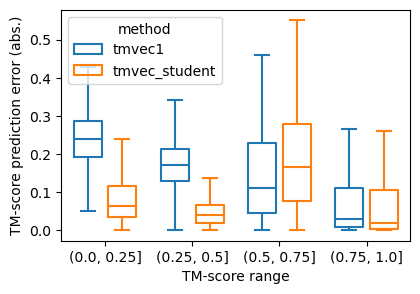

In [19]:
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.boxplot(data=df_err_bin_melt, x='bin', y='error', hue='method', hue_order=methods[:2], fill=False, showfliers=False, gap=0.2)
ax.set_xlabel('TM-score range')
ax.set_ylabel('TM-score prediction error (abs.)')
fig.savefig('plots/tmscore_error_bin.svg')

Accuracy (vs. TM-align)

In [20]:
df_score = df.drop(columns='foldseek').dropna(how='any')
print(df_score.shape[0])

491536


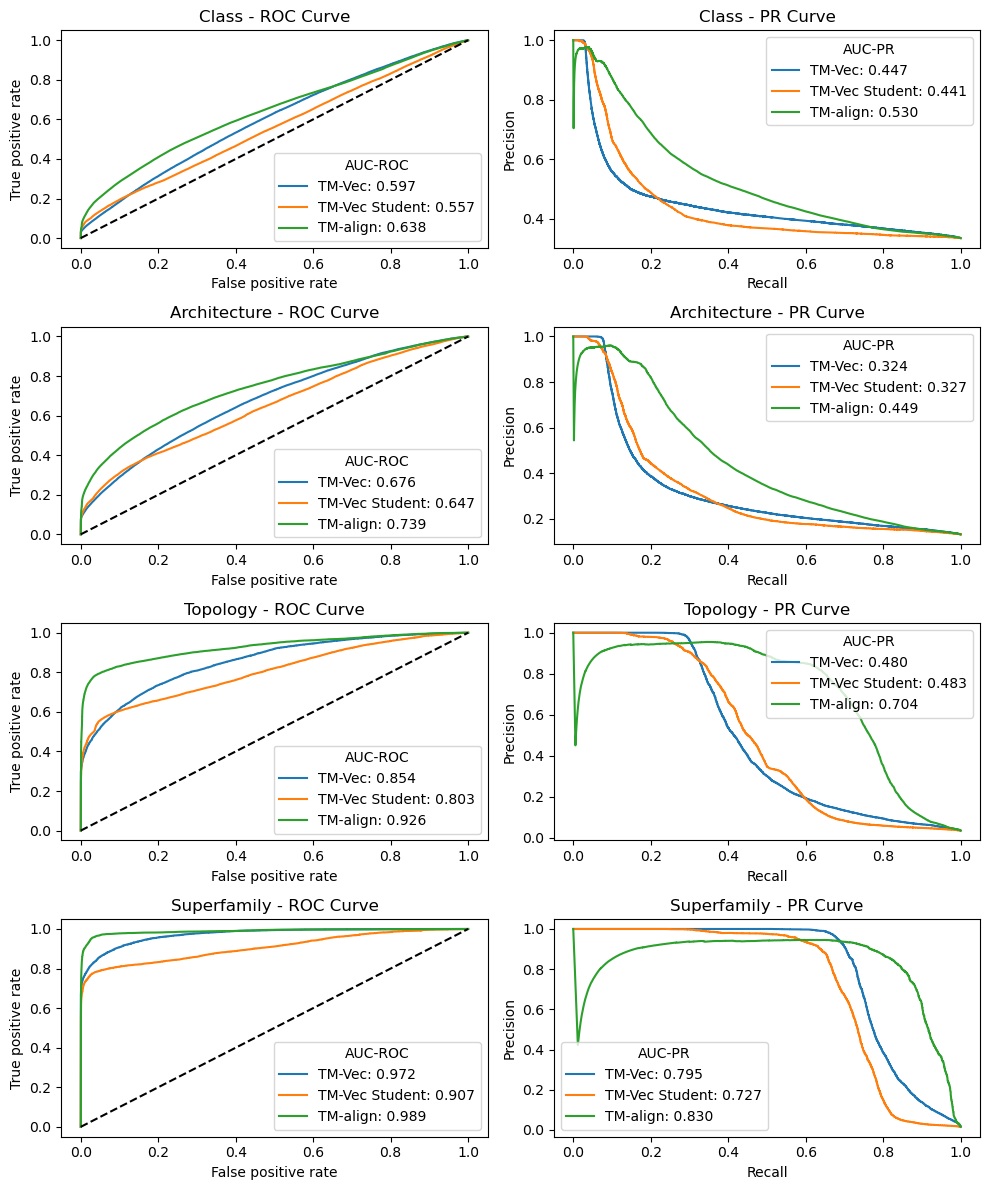

In [21]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
for i, level in enumerate(levels):
    y_true = df_score[level].to_numpy()

    ax = axes[i, 0]
    for method, name in zip(methods[:3], names[:3]):
        y_score = df_score[method].to_numpy()
        auroc = roc_auc_score(y_true, y_score)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, label=f'{name}: {auroc:.3f}')
    ax.legend(title='AUC-ROC')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(f'{level.capitalize()} - ROC Curve')

    ax = axes[i, 1]
    for method, name in zip(methods[:3], names[:3]):
        y_score = df_score[method].to_numpy()
        aupr = average_precision_score(y_true, y_score)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ax.plot(recall, precision, label=f'{name}: {aupr:.3f}')
    ax.legend(title='AUC-PR')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{level.capitalize()} - PR Curve')
fig.tight_layout()
fig.savefig('plots/tmscore_accuracy.svg')

Accuracy (vs. Foldseek)

In [22]:
df_fold = df.drop(columns='tmalign').dropna(how='any')
print(df_fold.shape[0])

65100


In [23]:
values = df_fold['foldseek'].to_numpy()
values[values == 0] = values[values > 0].min() * 0.1
df_fold['foldseek'] = -np.log10(values)

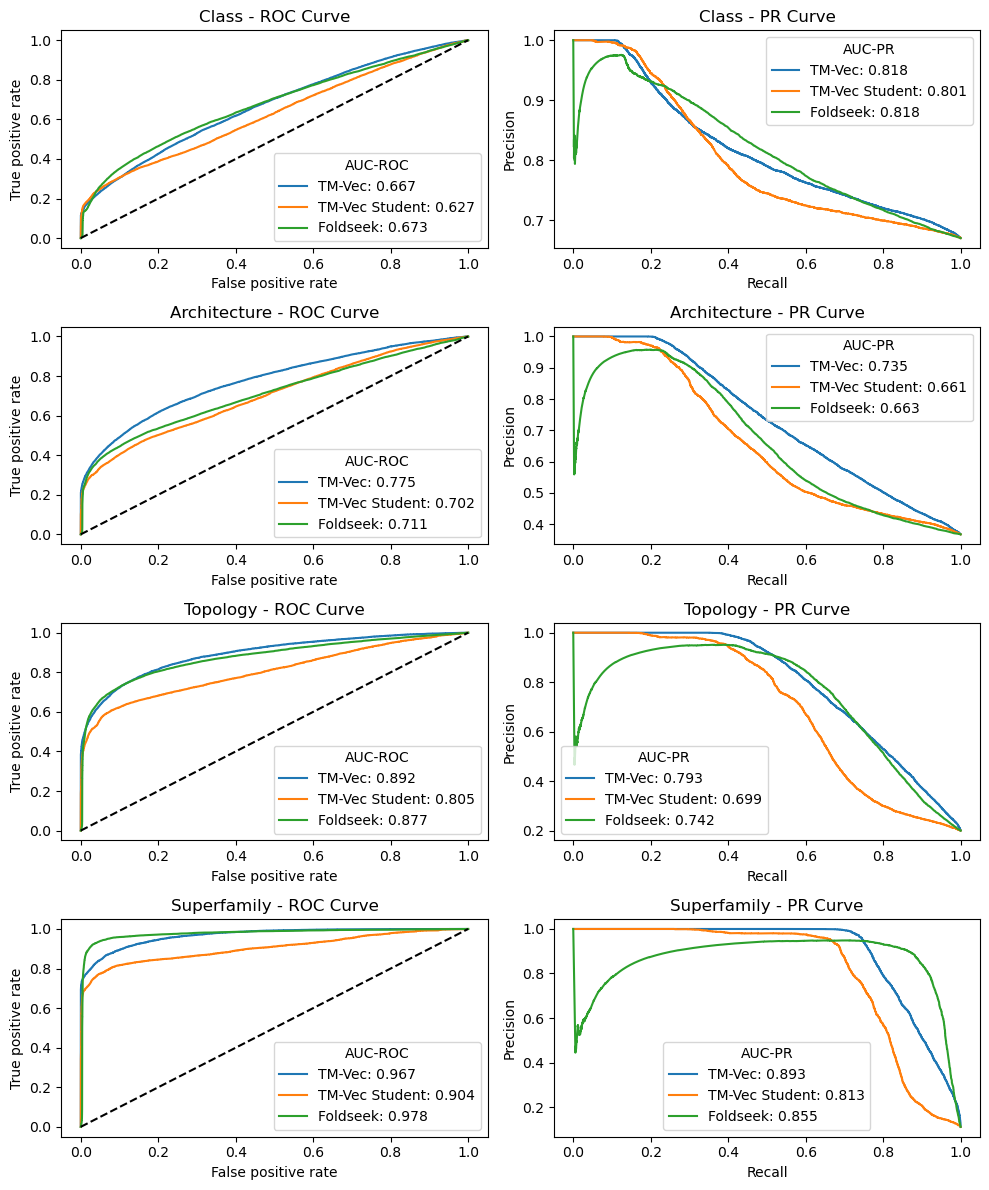

In [24]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
for i, level in enumerate(levels):
    y_true = df_fold[level].to_numpy()

    ax = axes[i, 0]
    for j in (0, 1, 3):
        y_score = df_fold[methods[j]].to_numpy()
        auroc = roc_auc_score(y_true, y_score)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, label=f'{names[j]}: {auroc:.3f}')
    ax.legend(title='AUC-ROC')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(f'{level.capitalize()} - ROC Curve')

    ax = axes[i, 1]
    for j in (0, 1, 3):
        y_score = df_fold[methods[j]].to_numpy()
        aupr = average_precision_score(y_true, y_score)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ax.plot(recall, precision, label=f'{names[j]}: {aupr:.3f}')
    ax.legend(title='AUC-PR')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{level.capitalize()} - PR Curve')
fig.tight_layout()
fig.savefig('plots/foldseek_accuracy.svg')